# Delayed reporting estimation - a triangle-free approach

In the insurance sector, an investigation of Incurred But Not Reported (IBNR) losses needs to be taken into account when properly assessing risk due to there often being a delay between the incident date and the reporting date for various reasons. As such, before prospective pricing is undertaken, IBNR needs to be applied to the current claims history and this notebook demonstrates one possible approach.

## Assumptions

A delay distribution is often modeled by an exponential distribution because this is the probability distribution of time between independent events occuring at a constant rate (i.e. a Poisson point process), which in turn is a generally accepted distribution for claims frequency.

As such, we will use the exponential distribution in this notebook, although the ideas and algorithms here can be generalized to other distributions that may suit the data better.

## Testing Example

To test this modeling technique, let us suppose we have a fictitious motor fleet policy of 440 vehicles each year that lasted 5 years, however, prior to renewal, we have a total of 4 years and 9 months of claims experience with a total of 562 claims. Suppose also that the average observed delay is 1 month. We encapsulate the data as follows:

In [1]:
motor_policy = {
    'Total_claims': 440.,
    'Policy_length': 5.,
    'Reporting_years': 4. + 9./12,      # 4.75
    'Average_reporting_delay': 1./12,   # 0.083
    'Total_vehicle_years': 375*(4+9/12) # 1781.25
}

# Import the libraries needed
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton # Root-finding algorithm

## Bias Correction
The oberved delay in our motor policy is most likely biased because we cannot observe delays larger than in the given data. To correct for this, we will use Bayes' theorem and reformulate the average reporting delay as given to be the reporting delay given the observed policy period (reporting years in the example).

Define $T$ to be the random variable that models delay between the incident date and the reporting date.

As a result, the relationship between the observed reporting delay, $\tau'$ and the true reporting delay $\tau$ is given by

$$ \tau' = E[T] = \frac{1}{1-\frac{\tau}{a} (1-e^{-a/t}))} \int_0^a \frac{t}{\tau} \left(1 - \frac{t}{a} \right) e^{(-t/\tau)} \, dt $$

$$ = \tau \left( 1 + \frac{e^{(-a/\tau)}-\frac{\tau}{a} (1-e^{(-a/\tau)})}{1-\frac{\tau}{a}(1-e^{(-a/\tau)})} \right) $$

where $a$ is the policy reporting length.

To find $\tau$ and thus obtain a bias-corrected estimate of delay, we solve the above equation. We can use a numerical technique such as the secant method (we could alternatively use the Newton-Raphson method, which has better convergence rates, but we need to manually calculate the derivative for that). 

In [2]:
def __t_avg(t_True, t_Obs, a):
    return t_True * ( 1 + (np.exp(-a/t_True) - t_True/a * (1 - np.exp(-a/t_True)) / (1 - (t_True/a) * (1 - np.exp(-a/t_True))))) - t_Obs

# We need to make an initial guess of the parameter, and since the true value is likely not far from the observed, we add a small amount to the observed
tObserved = motor_policy['Average_reporting_delay'] 
t0 = tObserved + 0.01
upper = motor_policy['Policy_length'] # Corresponds to 'a'

tau = newton(__t_avg, t0, args=[tObserved, upper])
print("Calculated true average delay:", format(tau,".3f"))

Calculated true average delay: 0.085


We need to validate this by having a plot of the function we are solving for $\tau$. As the function is non-linear, it is likely to have multiple roots (or even none), so we want to see if the calculated delay is the delay we want (if not, we re-run the above with a starting t0 to be closer to the other root).

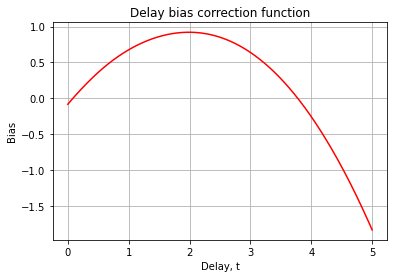

In [3]:
x = np.linspace(0,upper,500)
y = __t_avg(x, tObserved, upper)
plt.plot(x,y,color='red')
plt.grid()
plt.title("Delay bias correction function")
plt.xlabel("Delay, t")
plt.ylabel("Bias")
plt.show()

## First Execution

If an incident occurs at time $t$, then the chance that it is observed within the relative timeframe of $[0,a]$ is $F(a-t)$ where $F$ is the cumulative distribution function of the delay. 

Consider the time interval $(t,t+dt)$. Then the expected number of claims in this interval is $N(t,t+dt) = Ndt/a'$, where $a'$ denotes the upper limit of an arbitrary interval with $a>a'$. 

The number of claims occurring in $(t,t+dt)$ and reported within $[0,a]$ is $N(t,t+dt)F(a-t) = (N/a') F(a-t)dt$, hence the number of claims occurring in $[0,a']$ and reported in $[0,a]$ is

$$ \frac{N}{a'} \int_0^{\min(a,a')} F(a-t)\,dt $$

Therefore to get the projected claim amounts, we invert the above to yield

$$ N = \frac{a'}{\int_0^{\min(a,a')} F(a-t)\,dt } \times \text{reported} $$

In our case, we use the exponential distribution, and we encapsulate the above formulation in the following function

In [4]:
def project(reported_tUpper, project_tUpper, param, reported_count):
    return reported_count * (project_tUpper / (project_tUpper - param * ( np.exp((project_tUpper - reported_tUpper)/param) - np.exp(-reported_tUpper/param))))

We calculate the projected amount for the full policy period.

In [5]:
projected = project(motor_policy['Reporting_years'], motor_policy['Policy_length'], tau, motor_policy['Total_claims'])

print("Projected total claims at completion:", format(projected, ".3f"))
print("IBNR:", format(projected-motor_policy['Total_claims'], ".3f"))

Projected total claims at completion: 650.363
IBNR: 210.363


## Uncertainty

We fall back to the underlying claim frequency distribution, which we assume to be Poisson in this case. Then both the reported number of claims and the IBNR claims follow Poisson distributions. Then, since the variance is equal to the mean for Poisson distributed random variables, we have that the standard error of the ultimate claim count is

$$ \sqrt{\text{projected}-\text{reported}}

In [6]:
print("Standard error:", format(np.sqrt(projected-motor_policy['Total_claims']), ".3f"))

Standard error: 14.504


## Further Discussion
The methods here can be generalized to other distributions based on different processes (e.g. negative binomial frequency distribution). This could also be used to estimate IBNER (Incurred But Not Enough Reserved) for the missing claim volumes, which typically follow a lognormal process. The above example of a corresponding exponential delay distribution may therefore need to be changed for an alternative that may better fit the empirical data.

Source: Parodi, Pietro: "Triangle-free reserving: a non-traditional framework for estimating reserves and reserve uncertainty.", Date: 2013-02-04, Presented to the Institute and Faculty of Actuaries.